In [77]:
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, Expression, Function, functionspace, locate_dofs_topological,
                         assemble_scalar, dirichletbc, form, locate_dofs_geometrical)
from dolfinx.fem.petsc import LinearProblem
from dolfinx import mesh
from dolfinx.plot import vtk_mesh


from mpi4py import MPI
from ufl import (SpatialCoordinate, TestFunction, TrialFunction, inner, dot, ds, dx, grad, Mesh,
                 triangle, nabla_div, Identity, sym, tr, sqrt)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyvista, pygmsh, gmsh, meshio

In [78]:
def generate_l_shaped_mesh(x_min: float, x_max: float, y_min: float, y_max: float, h: float):
    z = 0.0
    x_mid = (x_min + x_max)/2
    y_mid = (y_min + y_max)/2
    h_vtcs = h
    with pygmsh.geo.Geometry() as geom:
        points = [
            geom.add_point([x_min, y_min, z], mesh_size=h_vtcs),
            geom.add_point([x_mid, y_min, z], mesh_size=h_vtcs),
            geom.add_point([x_mid, y_mid, z], mesh_size=h_vtcs/10),
            geom.add_point([x_max, y_mid, z], mesh_size=h_vtcs),
            geom.add_point([x_max, y_max, z], mesh_size=h_vtcs),
            geom.add_point([x_min, y_max, z], mesh_size=h_vtcs),
        ]

        lines = [
            geom.add_line(points[0], points[1]),  # Bottom horizontal
            geom.add_line(points[1], points[2]),  # Right vertical
            geom.add_line(points[2], points[3]),  # Inner horizontal
            geom.add_line(points[3], points[4]),  # Inner vertical
            geom.add_line(points[4], points[5]),  # Top horizontal (left part)
            geom.add_line(points[5], points[0]),  # Left vertical
        ]
        
        # Create a line loop to define the L-shaped domain boundary
        line_loop = geom.add_curve_loop(lines)
        
        surface = geom.add_plane_surface(line_loop)

        mesh = geom.generate_mesh()

    return mesh

In [79]:
def plot_errors(h, e, l, x_label='$h$', y_label='$\epsilon_{L_2}$', title=''):
    """
    Plots the error vs mesh size on a log-log plot.

    Args:
    h : array-like
        Vector of mesh sizes.
    e : 2D array-like
        Matrix where each row corresponds to the errors for a specific label.
    l : array-like
        List of labels for each row in the error matrix.
    """
    
    plt.figure(figsize=(8, 6))
    
    for i, label in enumerate(l):
        plt.loglog(h[i], e[i], label=label, marker='o')
    
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=14)
    
    plt.legend()
    
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.show()

In [80]:
def generate_error_table_general(ms, e, l):
    """
    Generates a pandas DataFrame containing mesh sizes, errors, and convergence rates.
    This version handles any number of error rows.
    
    Args:
    - ms: List of mesh sizes.
    - e: List of lists containing error data for different methods.
    - l: List of column labels (first label is for mesh sizes).
    
    Returns:
    - DataFrame containing errors and convergence rates.
    """
    
    # Create a pandas DataFrame with mesh sizes
    data = pd.DataFrame({l[0]: ms})
    
    # Add the error columns to the DataFrame
    for i in range(1, len(l)):
        data[l[i]] = e[i-1]
    
    # Function to calculate convergence rates
    def compute_convergence_rates(errors, mesh_sizes):
        rates = []
        for i in range(1, len(errors)):
            rate = np.log(errors[i] / errors[i-1]) / np.log(mesh_sizes[i] / mesh_sizes[i-1])
            rates.append(rate)
        rates.insert(0, np.nan)  # Insert NaN for the first entry where rate can't be computed
        return rates

    # Add the convergence rate columns
    for i in range(1, len(l)):
        rate_col = f'rate_{l[i]}'
        data[rate_col] = compute_convergence_rates(e[i-1], ms)

    return data


In [81]:
x_min, x_max = -1, 1  # Lower-left corner
y_min, y_max = -1, 1 # Upper-right corner

h = 1/8 # Mesh size
element_order = 8

In [82]:
mesh_io = generate_l_shaped_mesh(x_min, x_max, y_min, y_max, h)

points = mesh_io.points[:, :2]  # Only take the 2D coordinates
triangle_cells = [cell for cell in mesh_io.cells if cell.type == "triangle"]
cells = np.vstack([cell.data for cell in triangle_cells])

ufl_domain = Mesh(triangle)
domain = mesh.create_mesh(MPI.COMM_WORLD, cells.astype(np.int32), points, ufl_domain)

d_dim = domain.geometry.dim
b_dim = d_dim - 1

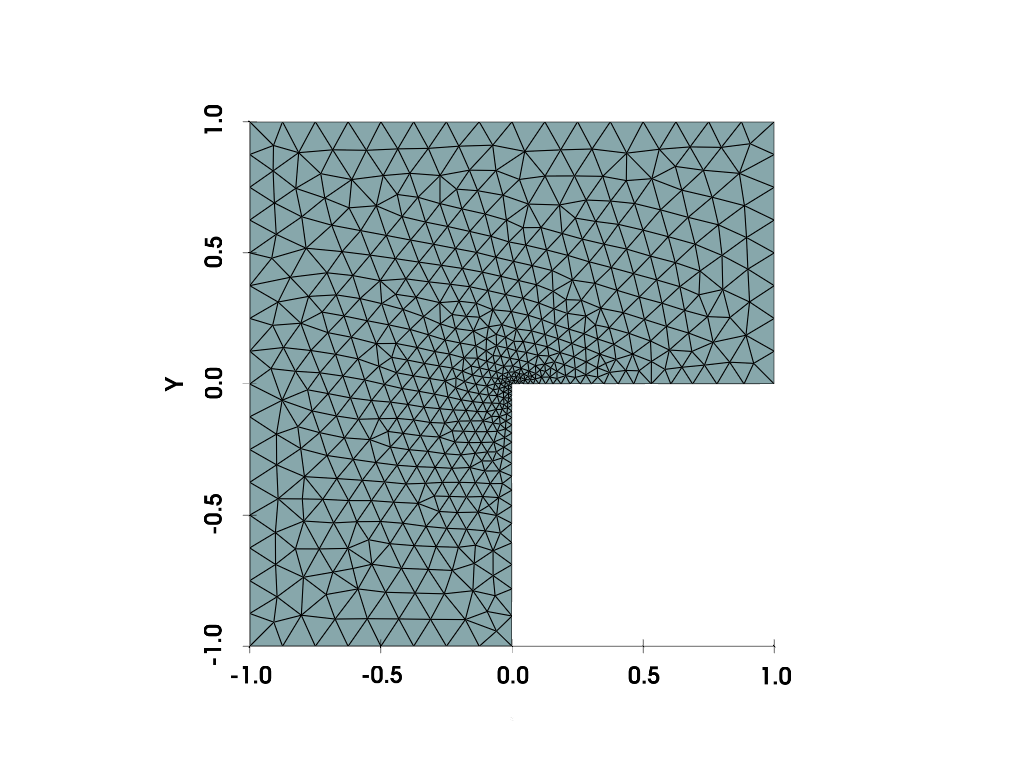

In [83]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(domain, 2)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid(
    xtitle='X',        # Custom label for X axis
    ytitle='Y',        # Custom label for Y axis
    grid=None               # Suppress grid lines
)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

In [84]:
V = functionspace(domain, ("Lagrange", element_order))

In [85]:
def u_exact(x, tol=1e-3):
    r = np.sqrt(x[0]**2+x[1]**2)
    theta0 = np.arctan2(x[1],x[0])

    theta = np.where(theta0 < -tol, theta0 + 2 * np.pi, theta0)

    n = 2/3
    
    return -(r**n)*np.cos(n*theta)

domain.topology.create_connectivity(b_dim, d_dim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

u_ex = Function(V)
u_ex.interpolate(u_exact)

boundary_dofs = locate_dofs_topological(V, b_dim, boundary_facets)
bc = dirichletbc(u_ex, boundary_dofs)

In [86]:
u = TrialFunction(V)
v = TestFunction(V)

a = dot(grad(u), grad(v)) * dx
f = Constant(domain, default_scalar_type(0))
b = f * v * dx

In [87]:
problem = LinearProblem(a, b, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "cholesky"})
uh = problem.solve()

2024-10-11 08:26:07.827 ( 256.486s) [main            ]              cells.cpp:43    WARN| 8th order mesh is untested


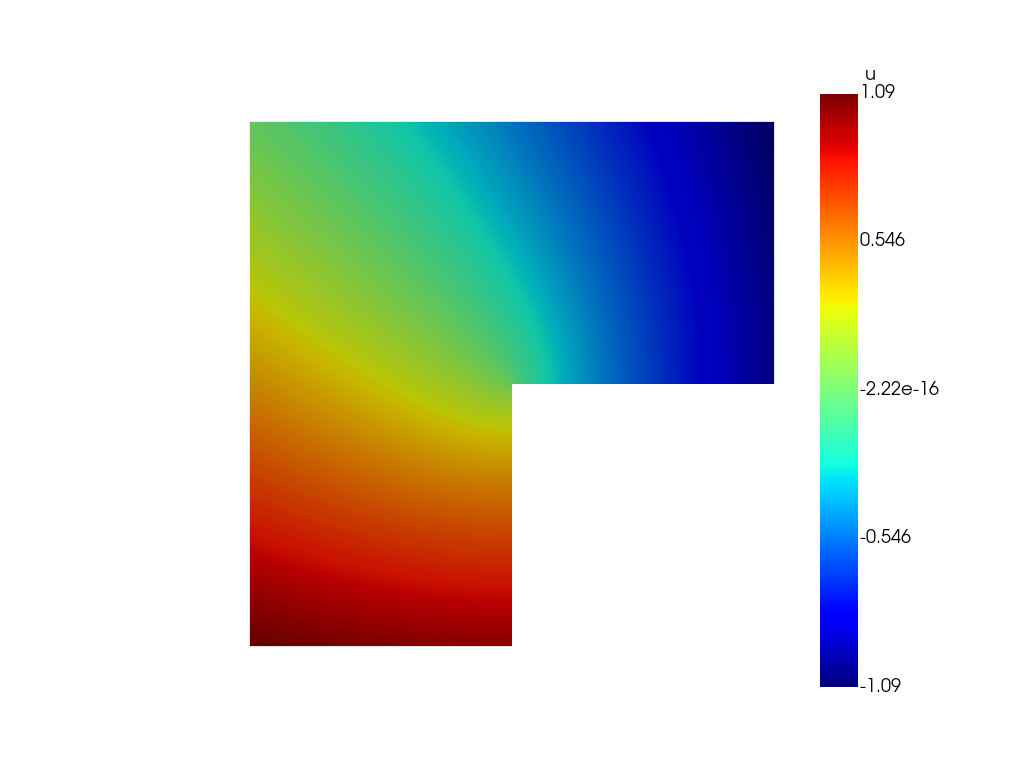

In [88]:
u_topology, u_cell_types, u_geometry = vtk_mesh(V)

u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()

scalar_bar_args = {"title": "u", "vertical": True, "position_x": 0.8, "position_y": 0.1, "width": 0.1, "height": 0.8}
u_plotter.add_mesh(u_grid, show_edges=False, cmap="jet", scalar_bar_args=scalar_bar_args)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [89]:
# vel = grad(uh)

# V_vel = functionspace(domain, ("Lagrange", element_order - 1, (d_dim,)))
# vel_expr = Expression(vel, V_vel.element.interpolation_points())
# velocity = Function(V_vel)
# velocity.interpolate(vel_expr)

In [90]:
# v_topology, v_cell_types, v_geometry = vtk_mesh(V_vel)
# v_grid = pyvista.UnstructuredGrid(v_topology, v_cell_types, v_geometry)
# v_grid.point_data["v"] = velocity.x.array.real
# v_grid.set_active_scalars("v")
# s_plotter = pyvista.Plotter()

# s_plotter.add_mesh(grid, show_edges=False)

# # Add arrows to represent the vector field
# plotter.add_arrows(grid.points, grid.point_data["v"], mag=0.5)  # 'mag' is the scaling factor for the arrow size

# plotter.show()

In [91]:
V2 = functionspace(domain, ("Lagrange", element_order))
u_ex = Function(V2)
u_ex.interpolate(u_exact)

error_L2 = assemble_scalar(form((uh - u_ex)**2 * dx))
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.x.array
n_dof = u_vertex_values.shape[0]

u_ex_vertex_values = u_ex.x.array

error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print(f"Mesh size : {h}")
print(f"Number of degrees of freedom: {n_dof}")
print(f"Error_L2 : {error_L2:.6e}")
print(f"Error_max : {error_max:.6e}")

Mesh size : 0.125
Number of degrees of freedom: 35433
Error_L2 : 8.368895e-07
Error_max : 1.572352e-04


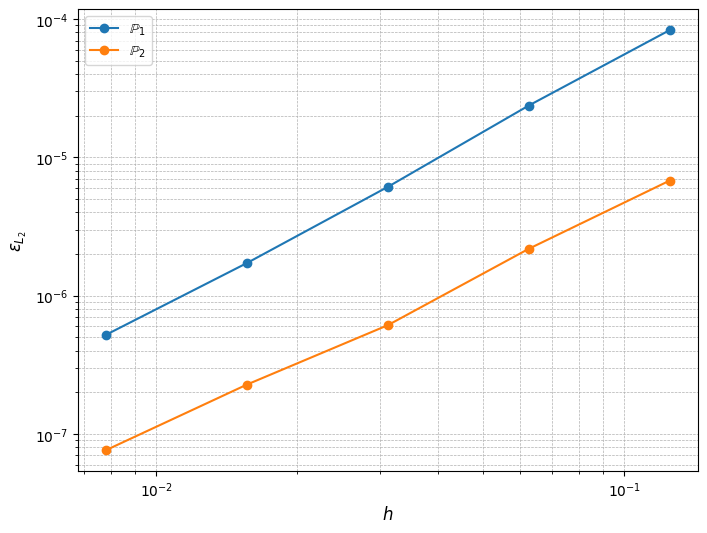

In [92]:
ms = [[0.125, 0.0625, 0.03125, 0.015625, 0.0078125]]*2
e = [
    [8.322112e-05, 2.370446e-05, 6.120278e-06, 1.721117e-06, 5.211520e-07],
    [6.792047e-06, 2.181295e-06, 6.115273e-07, 2.274612e-07, 7.633107e-08]]
l = ['$\mathbb{P}_1$', '$\mathbb{P}_2$']

plot_errors(ms, e, l)

In [93]:
general_error_table = generate_error_table_general(ms[1], e, ['$h$'] + l)
general_error_table

,$h$,$\mathbb{P}_1$,$\mathbb{P}_2$,rate_$\mathbb{P}_1$,rate_$\mathbb{P}_2$
0,0.125000,8.322112e-05,6.792047e-06,NaN,NaN
1,0.062500,2.370446e-05,2.181295e-06,1.811791,1.638662
2,0.031250,6.120278e-06,6.115273e-07,1.953489,1.834696
3,0.015625,1.721117e-06,2.274612e-07,1.830252,1.426796
4,0.007812,5.211520e-07,7.633107e-08,1.723569,1.575278


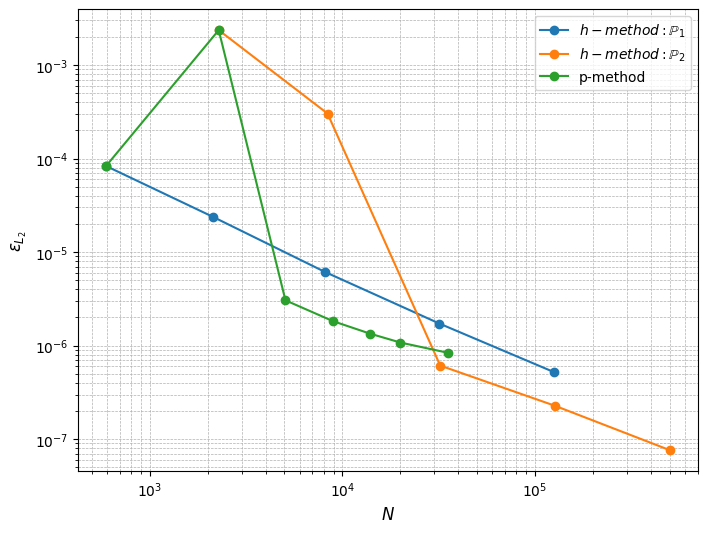

In [96]:
N = [
    [594, 2140, 8144, 31902, 125376],
    [2283, 8379, 32217, 126893, 500077],
    [594, 2283, 5068, 8949, 13926, 19999, 35433]]
e = [
    [8.322112e-05, 2.370446e-05, 6.120278e-06, 1.721117e-06, 5.211520e-07],
    [2.360597e-03, 3.029080e-04, 6.115273e-07, 2.274612e-07, 7.633107e-08],
    [8.322112e-05, 2.360597e-03, 3.049746e-06, 1.825521e-06, 1.342466e-06,1.079203e-06,8.368895e-07]]
l = ['$h-method: \mathbb{P}_1$', '$h-method: \mathbb{P}_2$', 'p-method']

plot_errors(N, e, l, '$N$')